In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image
import numpy as np
import os

def load_images_and_labels(image_folder):
    images = []
    labels = []
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)

        img = Image.open(img_path).resize((256, 256))
        img = np.array(img).flatten()
        images.append(img)

        label = int(img_file.split('_')[0])
        labels.append(label)

    return np.array(images), np.array(labels)

image_folder = '/content/drive/MyDrive/Deep_Learning/ProjectTask1/train_data'

X, y = load_images_and_labels(image_folder)

In [18]:
from sklearn.decomposition import PCA

n_components = 128
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = (F.relu(self.bn1(self.fc1(x))))
        x = F.relu(self.bn2(self.fc2(x)))
        x = (F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)

        return x

input_size = n_components
num_classes = len(np.unique(y))
learning_rate = 0.001
batch_size = 32

X_tensor = torch.tensor(X_reduced, dtype=torch.float32)
y_tensor = torch.tensor(y - 1, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN(input_size=n_components, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()

    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')

Epoch [1/50], Loss: 3.7172
Epoch [2/50], Loss: 3.1061
Epoch [3/50], Loss: 2.6586
Epoch [4/50], Loss: 2.2987
Epoch [5/50], Loss: 1.9611
Epoch [6/50], Loss: 1.6308
Epoch [7/50], Loss: 1.3815
Epoch [8/50], Loss: 1.1081
Epoch [9/50], Loss: 0.8770
Epoch [10/50], Loss: 0.7129
Epoch [11/50], Loss: 0.5466
Epoch [12/50], Loss: 0.4669
Epoch [13/50], Loss: 0.4024
Epoch [14/50], Loss: 0.3382
Epoch [15/50], Loss: 0.2620
Epoch [16/50], Loss: 0.2587
Epoch [17/50], Loss: 0.2575
Epoch [18/50], Loss: 0.2318
Epoch [19/50], Loss: 0.2041
Epoch [20/50], Loss: 0.1829
Epoch [21/50], Loss: 0.1814
Epoch [22/50], Loss: 0.1692
Epoch [23/50], Loss: 0.1255
Epoch [24/50], Loss: 0.1354
Epoch [25/50], Loss: 0.1453
Epoch [26/50], Loss: 0.1386
Epoch [27/50], Loss: 0.1472
Epoch [28/50], Loss: 0.1455
Epoch [29/50], Loss: 0.1302
Epoch [30/50], Loss: 0.1474
Epoch [31/50], Loss: 0.1526
Epoch [32/50], Loss: 0.1374
Epoch [33/50], Loss: 0.1400
Epoch [34/50], Loss: 0.1176
Epoch [35/50], Loss: 0.1039
Epoch [36/50], Loss: 0.1085
E

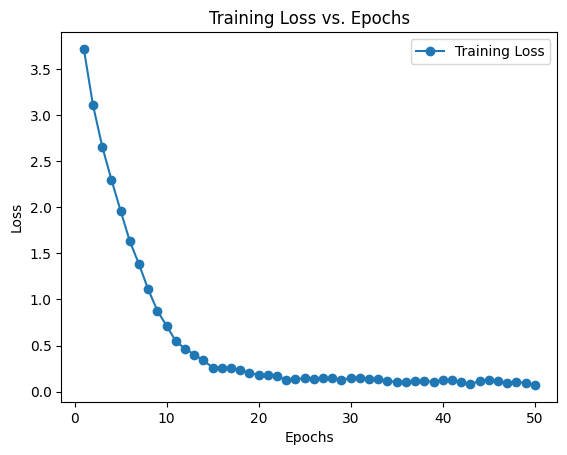

In [20]:
plt.plot(range(1, num_epochs + 1), losses, marker='o', label="Training Loss")
plt.title("Training Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Training Accuracy: {100 * correct / total}%')

Training Accuracy: 100.0%


In [22]:
val_folder = '/content/drive/MyDrive/Deep_Learning/ProjectTask1/val_data'
X_val,y_val = load_images_and_labels(val_folder)

X_reduced_val = pca.fit_transform(X_val)

X_tensor_val = torch.tensor(X_reduced_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val - 1, dtype=torch.long)

In [23]:
dataset_val = TensorDataset(X_tensor_val, y_tensor_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in dataloader_val:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Validation Accuracy: {100 * correct / total}%')

Validation Accuracy: 11.0%


## Cell For Testing: Just Update the Images and Weights Paths

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/Deep_Learning/ProjectTask1/val_data'
weights_path = '/content/drive/MyDrive/model_weights.pth'

from PIL import Image
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_images_and_labels(image_folder):
    images = []
    labels = []
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)

        img = Image.open(img_path).resize((256, 256))
        img = np.array(img).flatten()
        images.append(img)

        label = int(img_file.split('_')[0])
        labels.append(label)

    return np.array(images), np.array(labels)

X_val, y_val = load_images_and_labels(image_folder)

n_components = 128
pca = PCA(n_components=n_components)
X_reduced_val = pca.fit_transform(X_val)

X_tensor_val = torch.tensor(X_reduced_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val - 1, dtype=torch.long)

dataset = TensorDataset(X_tensor_val, y_tensor_val)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = (F.relu(self.bn1(self.fc1(x))))
        x = F.relu(self.bn2(self.fc2(x)))
        x = (F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)

        return x

model = NN(input_size=n_components, num_classes=60)
model.load_state_dict(torch.load(weights_path))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Testing Accuracy: {100 * correct / total}%')

Testing Accuracy: 9.833333333333334%


<ipython-input-24-f6a44c5a4cd2>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))
